Initialize KAN


In [1]:
import math
import warnings
from typing import Dict, Literal
import pandas as pd
warnings.simplefilter("ignore")
import delu  
import numpy as np
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn.functional as F
import torch.optim
from torch import Tensor
from tqdm.std import tqdm
from pandas import read_csv
warnings.resetwarnings()
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
from kan import *
import torch
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

cuda


In [2]:
def Test(model, CsvPath):
    
    label = '底缘单宽净动水荷载'

    test_data = read_csv(CsvPath, encoding = 'utf-8') #, header = None
    y_test = test_data[label]
    x_test = test_data.drop(columns=[label])
    #print(type(y_test))
    #print(type(x_test))
    y_test = np.array(y_test)
    x_test = np.array(x_test)
    #print(type(y_test))
    #print(type(x_test))
    #print(y_test.shape)
    #print(x_test.shape)
    #print(y_test[-1])
    #print(x_test[-1])

    Scaled_X_test = scaler_X.fit_transform(x_test)
    Scaled_y_test = scaler_y.fit_transform(y_test.reshape(y_test.shape[0], 1)) 
    x_test_tensor = torch.tensor(Scaled_X_test).to(device)
    y_test_tensor = torch.tensor(Scaled_y_test).to(device)

    rlt_list = []
    for item in model(x_test_tensor):
        #print(item.item())
        rlt_list.append(item.item())
    rlt_arr = np.array(rlt_list)
    #print(rlt_arr.shape)

    rlt_arr_inv = scaler_y.inverse_transform(rlt_arr.reshape(rlt_arr.shape[0], 1)) 
    for rlt in rlt_arr_inv:
        print(rlt.item())   

    print()
    print()
    
    # Evaluate the model
    y_pred = np.array(rlt_arr_inv)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))
    #print("Mean Absolute Percentage Error (MAPE):", safe_mape(y_test, y_pred).item(), "%")
    print("R² Score:", r2)

### Create dataset


In [3]:
label = '底缘单宽净动水荷载'

train_data = read_csv(r'D:\Data\NHRI\NHDF\KAN_Train.csv', encoding = 'utf-8') #, header = None
y_train = train_data[label]
x_train = train_data.drop(columns=[label])
print(type(y_train))
print(type(x_train))
y_train = np.array(y_train)
x_train = np.array(x_train)
print(type(y_train))
print(type(x_train))
print(y_train.shape)
print(x_train.shape)

print(x_train[-1])
print(y_train[-1])

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(600,)
(600, 3)
[112.84833  109.172134 107.472   ]
108.261


In [4]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler() 
Scaled_X_train = scaler_X.fit_transform(x_train)
Scaled_y_train = scaler_y.fit_transform(y_train.reshape(y_train.shape[0], 1))

x_train_tensor = torch.tensor(Scaled_X_train).to(device)
y_train_tensor = torch.tensor(Scaled_y_train).to(device)

In [5]:
dataset = create_dataset_from_data(x_train_tensor, y_train_tensor, device=device)
dataset['train_input'].shape, dataset['train_label'].shape
print(type(dataset))
#print(dataset)

<class 'dict'>


d:\Software\Anaconda\install\envs\pytorch\lib\site-packages\kan\MultKAN.py:556: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'{path}_state')
d:\Software

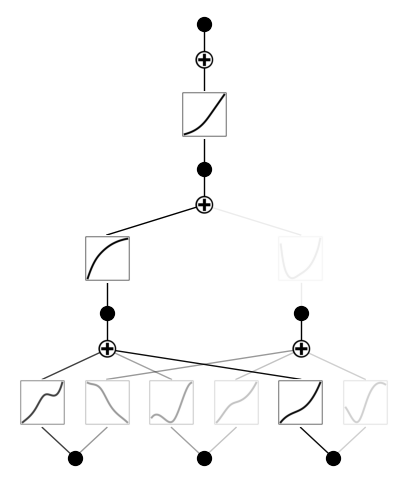

In [6]:
# revert to version 0.1 (if starting from scratch)
model = KAN.loadckpt(r'D:\Data\NHRI\NHDF\1\7.35e-03' + r'\0.3')
model.get_act(dataset)

model.plot()

In [7]:
# NOTE  1st test set
Test(model, r'D:\Data\NHRI\NHDF\1st_test_set.csv')

64.93684595398076
108.72627978899796
132.80134762029894
139.68302488585067
138.45669203609802
128.80388422158737
107.29956824779222
66.96342943798788


Mean Absolute Error (MAE): 3.435978271007329
Mean Squared Error (MSE): 19.482199068495937
Root Mean Squared Error (RMSE): 4.41386441437613
R² Score: 0.9739403744631733


In [8]:
# NOTE  2nd test set
Test(model, r'D:\Data\NHRI\NHDF\2nd_test_set.csv')

44.321273061889926
87.71773106558895
112.0531440595102
124.83234269395957
122.41875038331361
110.68880513686496
87.83139289591107
51.74903584223832


Mean Absolute Error (MAE): 1.953116126937096
Mean Squared Error (MSE): 8.02537437379354
Root Mean Squared Error (RMSE): 2.832909171469064
R² Score: 0.9906682810094332


In [9]:
# NOTE  3rd test set
Test(model, r'D:\Data\NHRI\NHDF\3rd_test_set.csv')

29.20337611282582
48.59494819675192
66.83381617798324
74.11674170659802
65.68742043952072
56.80236613059333
40.80538045179504
22.253875423092587


Mean Absolute Error (MAE): 1.7391024730865436
Mean Squared Error (MSE): 4.452166666528585
Root Mean Squared Error (RMSE): 2.11001579769645
R² Score: 0.9850562486004932


In [10]:
# NOTE  4th test set
Test(model, r'D:\Data\NHRI\NHDF\4th_test_set.csv')

119.64796655081473
151.34525034703248
146.4362239201069
136.41263111425832
164.9751787358696
144.27671763411976
116.18886022114009
107.50453617376314


Mean Absolute Error (MAE): 2.6174477851060374
Mean Squared Error (MSE): 15.094708130818425
Root Mean Squared Error (RMSE): 3.885190874438272
R² Score: 0.9531720450178783


In [11]:
# NOTE  5th test set
Test(model, r'D:\Data\NHRI\NHDF\5th_test_set.csv')

141.6669412016068
174.06048435088212
167.56588452563147
152.8034802267815
184.41203537406463
166.58221858247302
130.95665770727496
124.82639098274448


Mean Absolute Error (MAE): 2.31019480080926
Mean Squared Error (MSE): 15.297993113129495
Root Mean Squared Error (RMSE): 3.911264899380953
R² Score: 0.95538806275673


In [12]:
# NOTE  6th test set
Test(model, r'D:\Data\NHRI\NHDF\6th_test_set.csv')

173.8764725464676
192.51905693194908
212.25325528011845
192.4235017852089
216.73462806842232
198.12782778576957
170.08670615670744
151.5094535899833


Mean Absolute Error (MAE): 3.818744332086535
Mean Squared Error (MSE): 27.61740457996318
Root Mean Squared Error (RMSE): 5.2552264061563685
R² Score: 0.9271917545818564


In [13]:
# NOTE  7th test set
Test(model, r'D:\Data\NHRI\NHDF\7th_test_set.csv')

221.59166590172342
244.938338680765
253.76754305142975
257.33463978437135
253.30990139913484
232.71893509524415
201.780874101178
154.65130097604438


Mean Absolute Error (MAE): 2.3733246297252677
Mean Squared Error (MSE): 10.550854823975925
Root Mean Squared Error (RMSE): 3.2482079403843476
R² Score: 0.9895363925918833


In [14]:
# NOTE  8th test set
Test(model, r'D:\Data\NHRI\NHDF\8th_test_set.csv')

178.62070678139392
274.0632166925639
298.6829369335007
305.5846972602153
289.8321247291217
266.91671217068347
200.62514315673758
152.40921478245903


Mean Absolute Error (MAE): 4.30103947667066
Mean Squared Error (MSE): 33.111857815969216
Root Mean Squared Error (RMSE): 5.754290383354773
R² Score: 0.9882303769447134


In [15]:
# NOTE  9th test set
Test(model, r'D:\Data\NHRI\NHDF\9th_test_set.csv')

139.3426831883146
183.07009385303726
188.97221553317846
186.26838129073585
202.77238287086757
192.69605322316607
150.563660463928
122.43252767259143


Mean Absolute Error (MAE): 5.268882724790323
Mean Squared Error (MSE): 50.78435424110669
Root Mean Squared Error (RMSE): 7.1263142115056
R² Score: 0.9128609751910899
